# 패키지

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


%matplotlib inline

# plt.style.use('dark_background')


## 함수모음
- generator : input과 oupt을 만들어주는 함수
- plot_it : 학습후 모델 그래프를 만들고 저장해주는 함수
- mae_in_month : 정규화된 값을 학습시키기 때문에 개월로 변경한 mae계산해주는 함수

In [2]:
def generator(df,model,n):
    
    age = np.array(df.BA_z)
    img_size = model.input[1].shape[1]
    
    img_in = []   
    for file_path in df.roi_filename:
        img = cv2.imread(path+'/'+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
    img_in = np.array(img_in)
        
    if n==1:
        return img_in,age
    
    gender_in = np.array(df.gender)
    
    if n==2:
        return [gender_in,img_in],age
#     bimg_path = 
    bimg_size = model.input[0].shape[1]
    bimg_in = []
    for file_path in df.filename:
        img = cv2.imread(bimg_path+'/'+file_path)
        small = cv2.resize(img, (bimg_size,bimg_size),cv2.INTER_AREA)
        bimg_in.append(small)
    bimg_in = np.array(bimg_in)
    
    if n==3:
        return [bimg_in,img_in,gender_in],age
    
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
#     plt.show()
    fig = plt.gcf()
    fig.savefig("../04_model_visualization/"+model_name+".jpg")
#     plt.close(fig)

    
from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

## 데이터 파편화 줄이기 gpu 할당

In [3]:
from tensorflow.compat.v1 import ConfigProto,InteractiveSession
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

print(os.popen('nvidia-smi').read())

Thu Aug 20 11:19:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    54W / 300W |   5521MiB / 32480MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   36C    P0    52W / 300W |   5577MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## DataFrame 전처리
- 여기서 이미지 사이즈 조절
- 여기서 model이름 설정
- path 조절
- train_test_split

In [4]:
# df, img 불러오고 model화 시키기 전 전처리과정

model_name = "tjnet"
model_weight = model_name +"_weight.h5"

path = "../00_roi_final"



df = pd.read_excel(path+"/BA_Total.xlsx")
l = len(df)


df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std

file_name = np.array(["{0:03d}_05.jpg".format(i+1) for i in range(l)])
df["roi_filename"] = file_name


df["gender"] = (df["성별"]+1)%2

new_df = df.drop([219,425])
new_df = new_df.reset_index(drop=True)

## 모델 생성

In [5]:
import sys
sys.path.insert(0,'/home/centos/X-Age_Ver1/03_Modeling/01_model_module')

In [6]:
import CNN_model_module as models

model = models.tjnet2()
model.save("../03_model_result/"+model_name+".h5")

model.compile(loss ='mse', optimizer= 'nadam', metrics = [mae_in_months] )

## train_val_set 만들기

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_X,train_y = generator(train_df,model,2)
val_X,val_y = generator(val_df,model,2)

## preprocess

In [8]:
# from tensorflow.keras.applications.vgg19 import preprocess_input as pre
# train_X[1] = pre(train_X[1])
# val_X[1] = pre(val_X[1])

## 초반에 loss 심한거 뺄려고 한번만 먼저 돌리기

In [9]:
# model.load_weights("temp/"+model_weight)
model.fit(train_X,train_y,
                 validation_data = (val_X,val_y),
                 epochs = 1)

11/11 [==============================] - 4s 401ms/step - loss: 61712040.0000 - mae_in_months: 43036.2969 - val_loss: 1.1731 - val_mae_in_months: 15.6227


## 모델학습

Epoch 1/1000
11/11 [==============================] - 11s 987ms/step - loss: 0.9748 - mae_in_months: 14.8242 - val_loss: 1.1493 - val_mae_in_months: 15.3946 - lr: 0.0010
Epoch 2/1000
11/11 [==============================] - 10s 917ms/step - loss: 0.9256 - mae_in_months: 14.5337 - val_loss: 1.0195 - val_mae_in_months: 14.4880 - lr: 0.0010
Epoch 3/1000
11/11 [==============================] - 10s 937ms/step - loss: 0.9083 - mae_in_months: 14.3658 - val_loss: 0.8708 - val_mae_in_months: 13.3447 - lr: 0.0010
Epoch 4/1000
11/11 [==============================] - 10s 906ms/step - loss: 0.5815 - mae_in_months: 11.5060 - val_loss: 0.5644 - val_mae_in_months: 10.5814 - lr: 0.0010
Epoch 5/1000
11/11 [==============================] - 10s 925ms/step - loss: 0.4623 - mae_in_months: 10.0411 - val_loss: 0.5468 - val_mae_in_months: 10.2444 - lr: 0.0010
Epoch 6/1000
11/11 [==============================] - 10s 900ms/step - loss: 0.3619 - mae_in_months: 8.7956 - val_loss: 0.3103 - val_mae_in_months: 8.

Epoch 50/1000
11/11 [==============================] - 3s 287ms/step - loss: 0.0373 - mae_in_months: 2.4785 - val_loss: 0.1381 - val_mae_in_months: 5.1228 - lr: 0.0010
Epoch 51/1000
11/11 [==============================] - 3s 288ms/step - loss: 0.0450 - mae_in_months: 2.9148 - val_loss: 0.2389 - val_mae_in_months: 6.8779 - lr: 0.0010
Epoch 52/1000
11/11 [==============================] - 3s 287ms/step - loss: 0.0397 - mae_in_months: 2.7459 - val_loss: 0.1493 - val_mae_in_months: 5.6751 - lr: 0.0010
Epoch 53/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0397 - mae_in_months: 2.8025 - val_loss: 0.1521 - val_mae_in_months: 5.4189 - lr: 0.0010
Epoch 54/1000
11/11 [==============================] - 3s 287ms/step - loss: 0.0243 - mae_in_months: 2.0288 - val_loss: 0.1906 - val_mae_in_months: 6.0843 - lr: 0.0010
Epoch 55/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0431 - mae_in_months: 3.0027 - val_loss: 0.1694 - val_mae_in_months: 5.7409 - lr:

Epoch 99/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0429 - mae_in_months: 3.0157 - val_loss: 0.1434 - val_mae_in_months: 5.3179 - lr: 0.0010
Epoch 100/1000
11/11 [==============================] - 10s 921ms/step - loss: 0.0052 - mae_in_months: 1.0581 - val_loss: 0.1243 - val_mae_in_months: 5.0433 - lr: 0.0010
Epoch 101/1000
11/11 [==============================] - 10s 935ms/step - loss: 0.0030 - mae_in_months: 0.7834 - val_loss: 0.1234 - val_mae_in_months: 5.0439 - lr: 0.0010
Epoch 102/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0043 - mae_in_months: 1.0041 - val_loss: 0.1369 - val_mae_in_months: 5.1957 - lr: 0.0010
Epoch 103/1000
11/11 [==============================] - 3s 287ms/step - loss: 0.0016 - mae_in_months: 0.5687 - val_loss: 0.1271 - val_mae_in_months: 5.0440 - lr: 0.0010
Epoch 104/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0010 - mae_in_months: 0.4663 - val_loss: 0.1254 - val_mae_in_months: 5.014

11/11 [==============================] - 3s 287ms/step - loss: 0.0057 - mae_in_months: 1.0752 - val_loss: 0.1250 - val_mae_in_months: 4.9795 - lr: 0.0010
Epoch 148/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0024 - mae_in_months: 0.6693 - val_loss: 0.1232 - val_mae_in_months: 4.9331 - lr: 0.0010
Epoch 149/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0017 - mae_in_months: 0.5840 - val_loss: 0.1324 - val_mae_in_months: 5.1195 - lr: 0.0010
Epoch 150/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0015 - mae_in_months: 0.5891 - val_loss: 0.1232 - val_mae_in_months: 4.9399 - lr: 0.0010
Epoch 151/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0027 - mae_in_months: 0.7849 - val_loss: 0.1242 - val_mae_in_months: 4.9362 - lr: 0.0010
Epoch 152/1000
11/11 [==============================] - 3s 286ms/step - loss: 0.0048 - mae_in_months: 1.0476 - val_loss: 0.1505 - val_mae_in_months: 5.3886 - lr: 0.0010
E

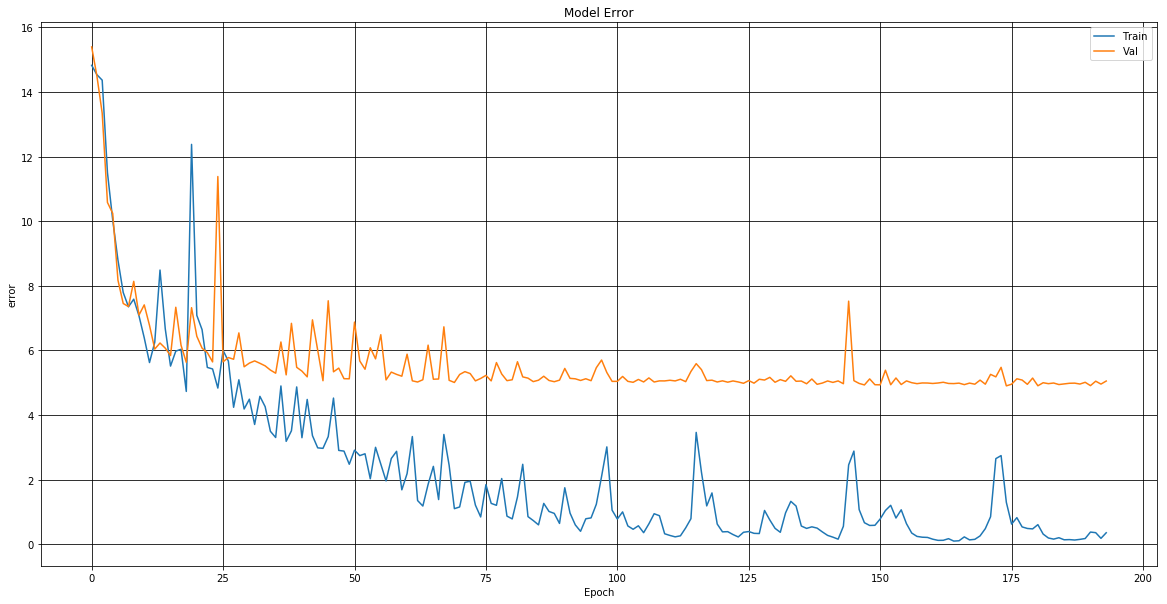

In [10]:
# 모델 fit

epochs = 1000
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 50,
                              verbose=0, mode='auto')

mc = ModelCheckpoint("temp/"+model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=50,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,mc,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)
plot_it(history)


## 평가 및 저장

In [11]:
model.load_weights("temp/"+model_weight)

In [12]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
r2 = r2_score(val_df.boneage,pred)
print(f"mae_year : {mae/12}, rmse : {mse/12},r2_score : {r2}" )

3/3 [==============================] - 0s 58ms/step - loss: 0.1222 - mae_in_months: 4.9706
mae_year : 0.41421349843343097, rmse : 0.010181749239563942,r2_score : 0.8938328189557851


In [13]:
from sklearn.metrics import mean_absolute_error
v = val_y*ba_std+ba_mean
mean_absolute_error(np.round(pred),v)/12,mean_absolute_error(pred,v)/12

(0.41329588014981283, 0.4142134912898032)

In [17]:
result_df = pd.read_csv("../03_model_result/result.csv")
result_df.loc[len(result_df)]=(model_name,mae/12,mse/12,r2,"gender,ROI(251*251)")
result_df.to_csv("../03_model_result/result.csv",index=False)
result_df

,model_name,mae,mse,r2_score,input
0,sample,0.000000,0.000000,1.000000,"gender,ROI(img_size*img_size)"
1,djnet,0.439692,0.011235,0.882849,"gender,ROI(251*251)"
2,sj_vgg_variation_weight.h5,0.439880,0.024005,0.865127,"gender,ROI(251*251)"
3,tjnet,0.444760,0.010932,0.886008,"gender,ROI(251*251)"
4,tjnet,0.428131,0.011775,0.877219,"gender,ROI(251*251)"


In [17]:
pred = model.predict(generator(df,model,2))*ba_std+ba_mean
month = np.array(df.boneage)
pred_all = pred.reshape(-1)

Text(0,0.5,'Predicted Age (Months)')

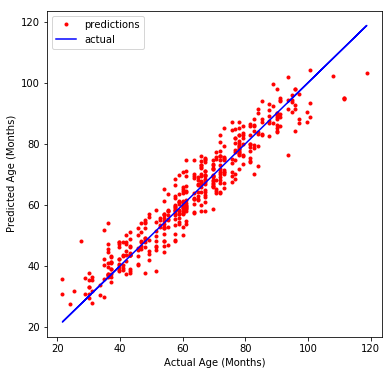

In [18]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(month, pred_all, 'r.', label = 'predictions')
ax1.plot(month, month, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [88]:
mean_absolute_error(np.round(pred_all),month)/12,mean_squared_error(pred_all,month)/12

(<tf.Tensor: shape=(), dtype=float64, numpy=0.2496220710506425>,
 1.3161097574794152)